In [36]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import json
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

import cv2
import pickle

In [3]:
dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

coco = COCO(anns_file_path)

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
        
super_cat_names.append("Nothing")
super_cat_ids["Nothing"] = nr_super_cats
        

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [4]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [5]:
ssResult = pickle.load( open( "ssResult.pickle", "rb" ) )


In [6]:
def IOU(rect1, rect2):
    boxA = [rect1[0], rect1[1], rect1[0]+rect1[2], rect1[1]+rect1[3]]
    boxB = [rect2[0], rect2[1], rect2[0]+rect2[2], rect2[1]+rect2[3]]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [7]:
def getCat(rect, anns):
    best_cat = -2
    best_iou = 0.2
    for ann in anns:
        iou = IOU(ann['bbox'], rect)
        if iou < best_iou:
            continue
        best_cat = ann['category_id']
        best_iou = iou
    if best_cat == -2:
        return -2
    if best_iou > 0.5:
        return best_cat
    return -1

In [30]:
class TACO(torch.utils.data.Dataset):
    def __init__(self, set_type, transform, data_path='dataset_path'):
        'Initialization'
        self.transform = transform
        data_path = dataset_path
        self.image_paths = []
        self.image_bbox = []
        self.image_cat = []
        self.image_ids = []
        for i in tqdm(range(len(imgs))):
            #if i > 10:
            #    return
            img = imgs[i]
            #batch_nr = int(os.path.split(img['file_name'])[0][6:])
            file_name = os.path.split(img['file_name'])[1]
            if file_name[0] == 'I':
                img_nr = int(file_name[6:8])
            else:
                img_nr = int(file_name[0:6])
            if set_type == "train":
                if not img_nr < 75:
                    continue
            elif set_type == "val":
                if not 75 <= img_nr < 90:
                    continue
            elif set_type == "test":
                if not 90 <= img_nr:
                    continue
            
            
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=[], iscrowd=None)
            anns_sel = coco.loadAnns(annIds)
            rects = ssResult[img['id']]

            for rect in rects:
                cat = getCat(rect, anns_sel)
                if cat == -2:
                    continue
                self.image_paths.append(dataset_path + "/" + img['file_name'])
                self.image_bbox.append(rect)
                self.image_ids.append(img['id'])
                self.image_cat.append(cat)
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        [x, y, w, h] = self.image_bbox[idx]
        image = image.crop((x,y,x+w,y+h))
        
        if self.image_cat[idx] != -1:
            y = super_cat_ids[categories[self.image_cat[idx]]['supercategory']]
        else:
            y = nr_super_cats
        X = self.transform(image)
        return X, y

In [1]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.ToTensor()
                                    ])



batch_size = 64
trainset = TACO("train", transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
print(len(trainset))
valset = TACO("val", transform=train_transform)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)
print(len(valset))
testset = TACO("test", transform=train_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
print(len(testset))

NameError: name 'transforms' is not defined

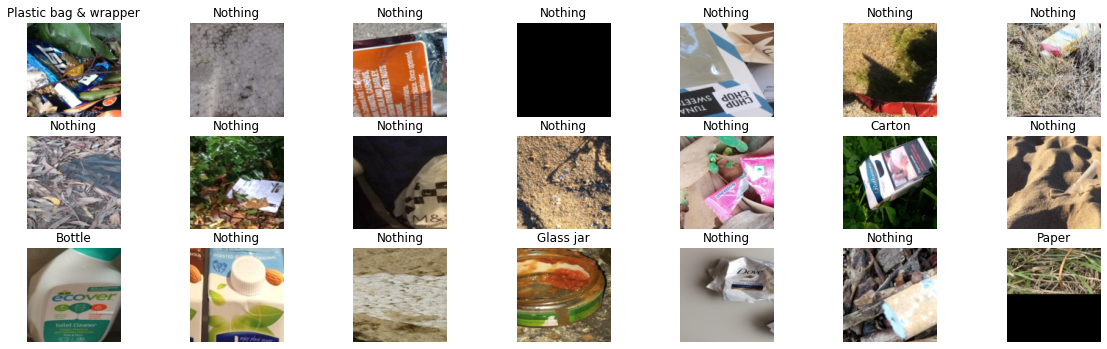

In [32]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(super_cat_names[labels[i]])
    plt.axis('off')


In [78]:
#We define the training as a function so we can easily re-use it.
def train(models,  optimizers, num_epochs=10):
    def loss_fun(output, target):
        loss = F.binary_cross_entropy
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            
            for i in range(nr_super_cats):
                target_this = torch.unsqueeze((target == i) * 1.0, dim=1)
                #Zero the gradients computed for each weight
                optimizers[i].zero_grad()
                #Forward pass your image through the network
                output = models[i](data)
                #Compute the loss
                loss = loss_fun(output, target_this)
                #Backward pass through the network
                loss.backward()
                #Update the weights
                optimizers[i].step()

                train_loss.append(loss.item())
                #Compute how many were correctly classified
                #predicted = output
                #train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            for i in range(nr_super_cats):
                with torch.no_grad():
                    output = models[i](data)
                    
                target_this = torch.unsqueeze((target == i) * 1.0, dim=1)
                test_loss.append(loss_fun(output, target_this).cpu().item())
                #predicted = output.argmax(1)
                #test_correct += (target==predicted).sum().cpu().item()
        #out_dict['train_acc'].append(train_correct/len(trainset))
        #out_dict['val_acc'].append(test_correct/len(testset))
        #out_dict['train_loss'].append(np.mean(train_loss))
        #out_dict['val_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t validation: {np.mean(test_loss):.3f}")
        
       
    return out_dict

In [82]:
class_models = []
class_optimizers = []

for i in range(nr_super_cats):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1),
                nn.Sigmoid()
        )
    model.to(device)
    class_models.append(model)
    
    
    lr = 0.00001
    class_optimizers.append(torch.optim.Adam(model.parameters(),lr=lr))


In [84]:
num_epoch = 30

out_dicts = train(class_models, class_optimizers, num_epoch)

for i in range(nr_super_cats):
    torch.save(model.state_dict(), "model_cat_" + str(i) + ".pt")

  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.055	 validation: 0.061


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.026	 validation: 0.043


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.015	 validation: 0.035


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.010	 validation: 0.030


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.007	 validation: 0.028


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.005	 validation: 0.026


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.004	 validation: 0.025


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.003	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.003	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.002	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.002	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.001	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.001	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.001	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.001	 validation: 0.024


  0%|          | 0/453 [00:00<?, ?it/s]

Loss train: 0.001	 validation: 0.025


  0%|          | 0/453 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1a79c24c0>
Traceback (most recent call last):
  File "/zhome/21/6/117441/P1_1/venv_p2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/zhome/21/6/117441/P1_1/venv_p2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/appl/python/3.9.11/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <functi

Loss train: 0.000	 validation: 0.030


  0%|          | 0/453 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1a79c24c0>
Traceback (most recent call last):
  File "/zhome/21/6/117441/P1_1/venv_p2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/zhome/21/6/117441/P1_1/venv_p2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/appl/python/3.9.11/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1a79c24c0>
Traceback (most recent call last):
  File "/zhome/21/6/117441/P1_1/venv_p2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/zhome/21/6/117441/P1_1/venv_p2/lib/python3.9/site-packages/torch/uti

Loss train: 0.000	 validation: 0.030


  0%|          | 0/453 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
torch.save(model.state_dict(), "model_resnet18.pt")

In [11]:
model_l = models.resnet18(pretrained=True)
num_ftrs = model_l.fc.in_features
model_l.fc = nn.Linear(num_ftrs, nr_super_cats+1)
model_l.load_state_dict(torch.load("model_resnet18.pt"))
model_l.to(device)
model_l.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
class TACO_test(torch.utils.data.Dataset):
    def __init__(self, transform, data_path='dataset_path'):
        'Initialization'
        self.transform = transform
        data_path = dataset_path
        self.image_paths = []
        self.image_ids = []
        for i in tqdm(range(len(imgs))):
            img = imgs[i]
            batch_nr = int(os.path.split(img['file_name'])[0][6:])
            if not 14 <= batch_nr:
                continue

            self.image_paths.append(dataset_path + "/" + img['file_name'])
            self.image_ids.append(img['id'])
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        if self.image_cat[idx] != -1:
            y = super_cat_ids[categories[self.image_cat[idx]]['supercategory']]
        else:
            y = nr_super_cats
        X = self.transform(image)
        return X, y

In [13]:
class out_obj():
    def __init__(self, rect, clas, score):
        self.rect = rect
        self.clas = clas
        self.score = score
        self.removed = False
        self.matched = False

all_outs_class = []
test_transform = transforms.ToTensor()
for i in tqdm(range(len(imgs))):
    img = imgs[i]
    batch_nr = int(os.path.split(img['file_name'])[0][6:])
    if not 14 <= batch_nr:
        pass#continue

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)
    rects = ssResult[img['id']]
    

    im_path = dataset_path + "/" + img['file_name']
    image = Image.open(im_path)
    image = test_transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to(device)
    
    outs = []
    for rect in rects:
        [x, y, w, h] = rect
        box = transforms.functional.crop(image,x,y,w,h)
        output = model_l(box)
        predicted = output.argmax(1)
        score = output[0][predicted]
        if predicted < nr_super_cats:
            outs.append(out_obj(rect, predicted, score))
        del box
    
    final_outs = []
    for class_id in range(nr_super_cats):
        class_outs = []
        for out in outs:
            if out.clas == class_id:
                class_outs.append(out)
                
        class_outs = sorted(class_outs, key=lambda x: x.score, reverse=True)
        for j in range(len(class_outs)):
            if class_outs[j].removed:
                continue
            for k in range(j+1, len(class_outs)):
                if class_outs[k].removed:
                    continue
                iou = IOU(class_outs[j].rect, class_outs[k].rect)
                if iou > 0.5:
                    class_outs[k].removed = True
        for out in class_outs:
            if not out.removed:
                final_outs.append(out)
    
    print("Number of total detections: " + str(len(outs)))
    print("Number of sorted detections: " + str(len(final_outs)))
    
    final_outs = sorted(final_outs, key=lambda x: x.score, reverse=True)
    GT_used = np.full(len(anns_sel), False)
    TP = 0
    precision = [1]
    recall = [0]
    for j in range(len(final_outs)):
        for k, ann in enumerate(anns_sel):
            if GT_used[k]:
                continue
            sup_cat = super_cat_ids[categories[ann['category_id']]['supercategory']]
            if final_outs[j].clas[0] != sup_cat:
                continue
            iou = IOU(ann['bbox'], final_outs[j].rect)
            if iou < 0.5:
                continue
            final_outs[j].matched = True
            GT_used[k] = True
            TP += 1
            break
        all_outs_class.append(final_outs[j])
        precision.append(TP / (j+1))
        recall.append(TP / len(GT_used))
    precision.append(0)
    recall.append(1)
    AP = np.trapz(precision, recall)
    print("Average Precision: " + str(AP))
    
    if False:
        # Show image
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(image)

        # Show annotations
        for out in final_outs:
            color = colorsys.hsv_to_rgb(np.random.random(),1,1)
            [x, y, w, h] = out.rect
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                             facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)
            print(super_cat_names[out.clas])

        plt.show()
    
    if i > 20:
        break

  0%|          | 0/1500 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 31.75 GiB total capacity; 20.59 GiB already allocated; 4.44 MiB free; 20.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [96]:
all_outs_class = sorted(all_outs_class, key=lambda x: x.score, reverse=True)
for i in range(nr_super_cats):
    TP = 0
    precision = [1]
    recall = [0]
    total_GT = len(coco.getAnnIds(imgIds=range(20), catIds=[], iscrowd=None))
    if total_GT == 0:
        continue
    for j in range(len(all_outs_class)):
        if all_outs_class[j].clas != i:
            continue
        if all_outs_class[j].matched:
            TP += 1
        precision.append(TP / (j+1))
        recall.append(TP / total_GT)
    precision.append(0)
    recall.append(1)
    AP = np.trapz(precision, recall)
    print("Average Precision of Class " + super_cat_names[i] + ": " + str(AP))
        

Average Precision of Class Aluminium foil: 0.5
Average Precision of Class Battery: 0.5
Average Precision of Class Blister pack: 0.5
Average Precision of Class Bottle: 0.17412155518736266
Average Precision of Class Bottle cap: 0.025219941348973606
Average Precision of Class Broken glass: 0.5
Average Precision of Class Can: 0.1594582238827763
Average Precision of Class Carton: 0.07361668634395907
Average Precision of Class Cup: 0.028321678321678322
Average Precision of Class Food waste: 0.5
Average Precision of Class Glass jar: 0.5
Average Precision of Class Lid: 0.5
Average Precision of Class Other plastic: 0.5
Average Precision of Class Paper: 0.5
Average Precision of Class Paper bag: 0.5
Average Precision of Class Plastic bag & wrapper: 0.034910147991543336
Average Precision of Class Plastic container: 0.5
Average Precision of Class Plastic glooves: 0.5
Average Precision of Class Plastic utensils: 0.5
Average Precision of Class Pop tab: 0.5
Average Precision of Class Rope & strings: 0

SyntaxError: invalid syntax (26662209.py, line 1)